In [ ]:
#Import Important libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
import plotly.express as px
from fbprophet.plot import plot_plotly, plot_components_plotly
from fbprophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose as sd
import plotly.graph_objects as go
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import missingno as msno
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor
from datetime import timedelta


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [ ]:
# import daat

features = pd.read_csv("features.csv", parse_dates=['Date'])
stores = pd.read_csv("stores.csv")
train = pd.read_csv("train.csv", parse_dates=['Date'])
test = pd.read_csv("test.csv", parse_dates=['Date'])

In [ ]:
#'   We will merge our datasets

tdf = train.merge(features, 'left').merge(stores, 'left')

# Merged data head

tdf.head(5)
# Percentage of missing Values

tdf.isna().sum()/len(tdf)*100




Store            0.000000
Dept             0.000000
Date             0.000000
Weekly_Sales     0.000000
IsHoliday        0.000000
Temperature      0.000000
Fuel_Price       0.000000
MarkDown1       64.257181
MarkDown2       73.611025
MarkDown3       67.480845
MarkDown4       67.984676
MarkDown5       64.079038
CPI              0.000000
Unemployment     0.000000
Type             0.000000
Size             0.000000
dtype: float64

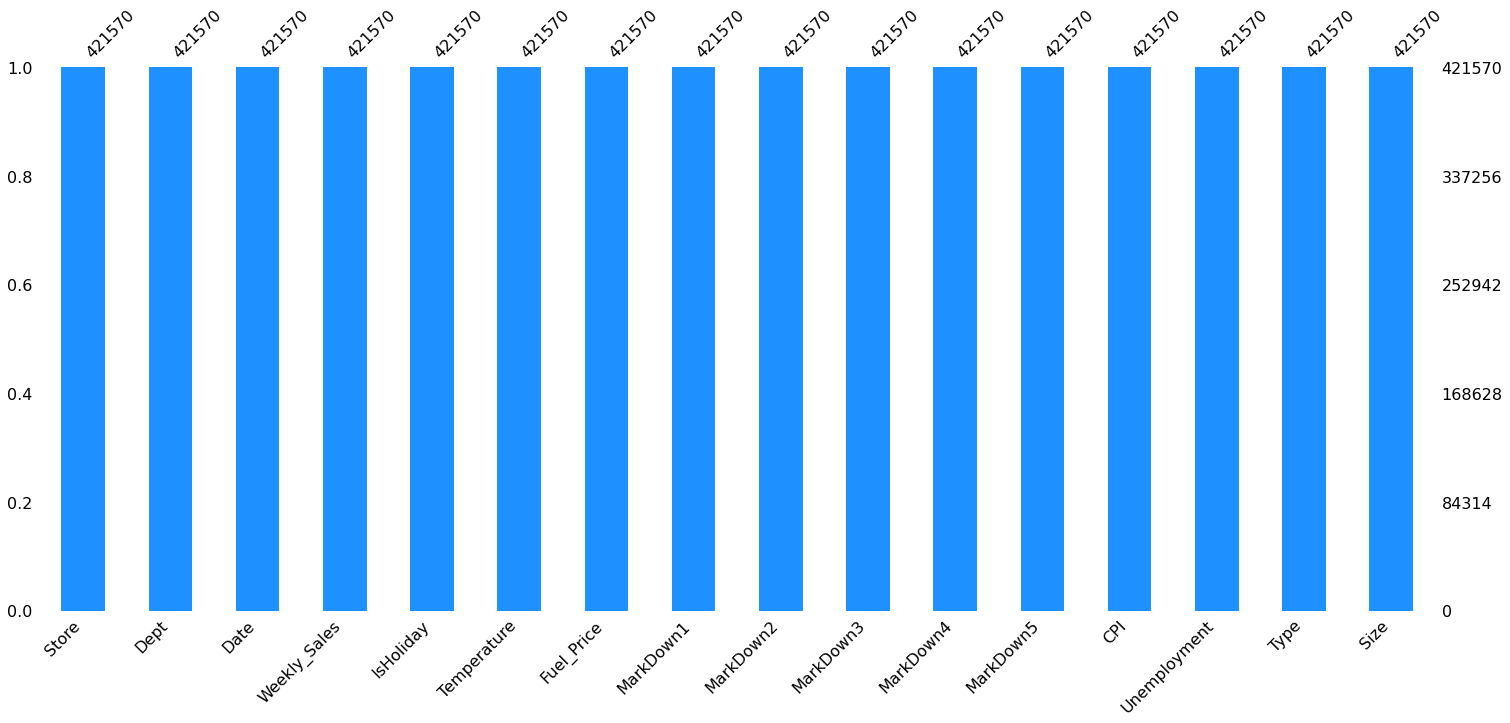

In [ ]:
# Missing data is for Markdowns only (Quantitative veriables). We can imput the missing data 
# using a 0, which indicates that there is no markdown.

tdf= tdf.fillna(0)
# DISPLAY MISSING DATA
msno.bar(tdf, color="dodgerblue")
plt.show()

In [ ]:
print(tdf.shape)

(70562, 16)


In [ ]:
tdf.to_csv('merged_data_MD_imputed_by_zero.csv')

In [ ]:
tdf['Date']= pd.to_datetime(tdf['Date']) 
tdf['year'] = tdf['Date'].dt.year
tdf[['Date','year']].head()
tdf.year.unique()

array([2010, 2011, 2012])

In [ ]:
tdf.head(3)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,FALSE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A,151315
1,1,1,2010-02-12,46039.49,TRUE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A,151315
2,1,1,2010-02-19,41595.55,FALSE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A,151315


In [ ]:
Stores = tdf["Store"]
Stores.head(3)

0    1
1    1
2    1
Name: Store, dtype: int64

In [ ]:
tdf1 = tdf.Store[tdf.Store=='1']

In [ ]:
tdf1 = tdf[tdf["Store"] == 1]

In [ ]:
tdf1.shape

(70562, 16)

In [ ]:
tdf2 = tdf1[tdf1["Dept"] == 1]

In [ ]:
tdf2.shape

(1144, 16)

In [ ]:
tdf2['Date']= pd.to_datetime(tdf2['Date']) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
tdf2['year'] = tdf2['Date'].dt.year
tdf2[['Date','year']].head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Date,year
0,2010-02-05,2010
1,2010-02-12,2010
2,2010-02-19,2010
3,2010-02-26,2010
4,2010-03-05,2010


In [ ]:
tdf2.year.unique()

array([2010, 2011, 2012])

In [ ]:
test= tdf2.groupby("Date")["Weekly_Sales"].sum()
test.to_csv('actualV1.csv')

In [ ]:
tdf3 = tdf2[tdf2["year"] <= 2011]

In [ ]:
tdf3.year.unique()

array([2010, 2011])

In [ ]:
tdf3.shape


(100, 17)

In [ ]:
ts=train.groupby("Date")["Weekly_Sales"].sum()
#ts=train.groupby("Date")["Weekly_Sales"].mean()

In [ ]:
ts1= tdf2.groupby("Date")["Weekly_Sales"].sum()

In [ ]:
ts1.head(3)

Date
2010-02-05    24924.50
2010-02-12    46039.49
2010-02-19    41595.55
Name: Weekly_Sales, dtype: float64

In [ ]:
ts1.to_csv('actual.csv')

In [ ]:
# Reset index
p_ts = ts1.reset_index()
p_ts.columns = ["ds","y"]
p_ts.head()

,ds,y
0,2010-02-05,24924.50
1,2010-02-12,46039.49
2,2010-02-19,41595.55
3,2010-02-26,19403.54
4,2010-03-05,21827.90


In [ ]:
p_ts.to_csv('actual.csv')

In [ ]:
# Fitting Prophet Model
m = Prophet(yearly_seasonality = True)
m.fit(p_ts)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
print(p_ts.shape)

(100, 2)


In [ ]:
# Display the future data (26 weeks)
future = m.make_future_dataframe(periods=52, freq='W')
future.tail()

,ds
190,2013-09-22
191,2013-09-29
192,2013-10-06
193,2013-10-13
194,2013-10-20


In [ ]:
print(future.shape)

(195, 1)


In [ ]:
ts1.head(2)

Date
2010-02-05    24924.50
2010-02-12    46039.49
Name: Weekly_Sales, dtype: float64

In [ ]:
# Predict future sales
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
190,2013-09-22,20447.101427,12490.272240,27968.111683
191,2013-09-29,20645.117221,13104.324648,28347.399456
192,2013-10-06,20481.030322,12727.920409,27720.741628
193,2013-10-13,22550.473809,15354.239031,30093.850852
194,2013-10-20,27714.194295,20368.145095,35448.501232


In [ ]:
forecast.to_csv('predictedV1.csv')

In [ ]:
# Visualize the forcasted sales
plot_plotly(m, forecast)

In [ ]:
plot(m, forecast)

In [ ]:
# Visualize the components
plot_components_plotly(m, forecast)

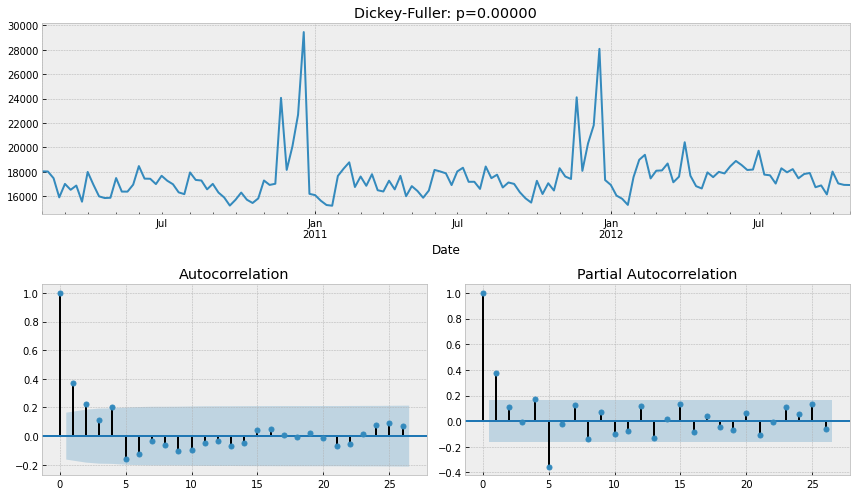

In [ ]:
def tsplot(ts, lags):
    with plt.style.context("bmh"):    
        fig = plt.figure(figsize=(12, 7))
        ts_ax = plt.subplot2grid((2, 2), (0, 0), colspan=2)
        acf_ax = plt.subplot2grid((2, 2), (1, 0))
        pacf_ax = plt.subplot2grid((2, 2), (1, 1))
        ts.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(ts)[1]
        ts_ax.set_title('Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(ts, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(ts, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(ts, 26)

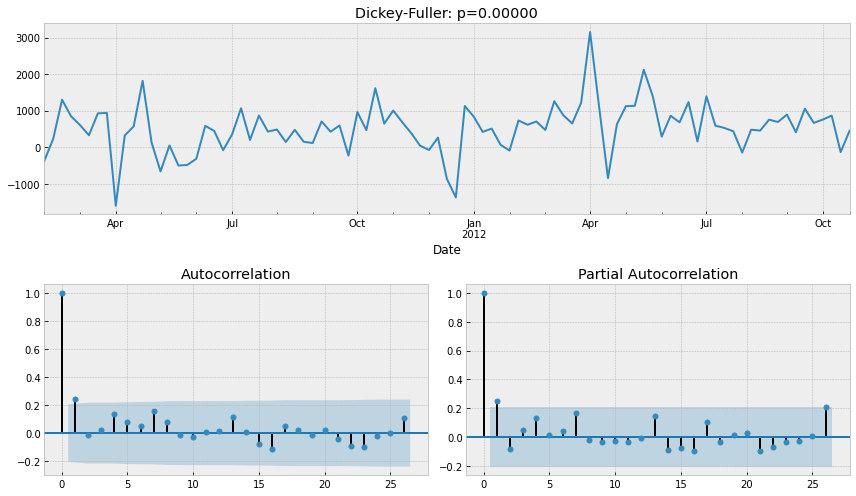

In [ ]:
ts_diff = ts - ts.shift(52)
tsplot(ts_diff[52:], 26)

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning:

invalid value encountered in sqrt



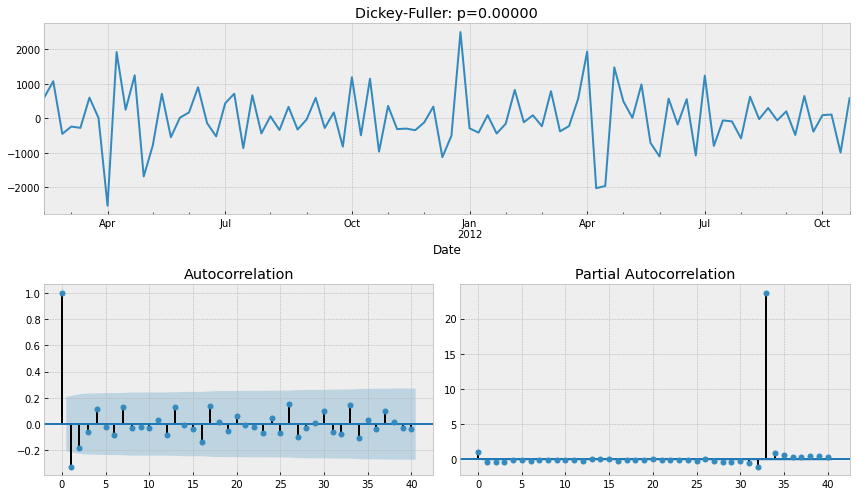

In [ ]:
ts_diff = ts_diff - ts_diff.shift(1)
tsplot(ts_diff[52+1:], 40)

In [ ]:
# Specify SARIMA Components & fit the model
p = 2
d=1 
q = 3
P = 2
D=1 
Q = 3
s = 52
model=sm.tsa.statespace.SARIMAX(ts, order=(p, d, q), seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(model.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency W-FRI will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



ValueError: ignored

In [ ]:
LINEAR MODELS

SyntaxError: ignored

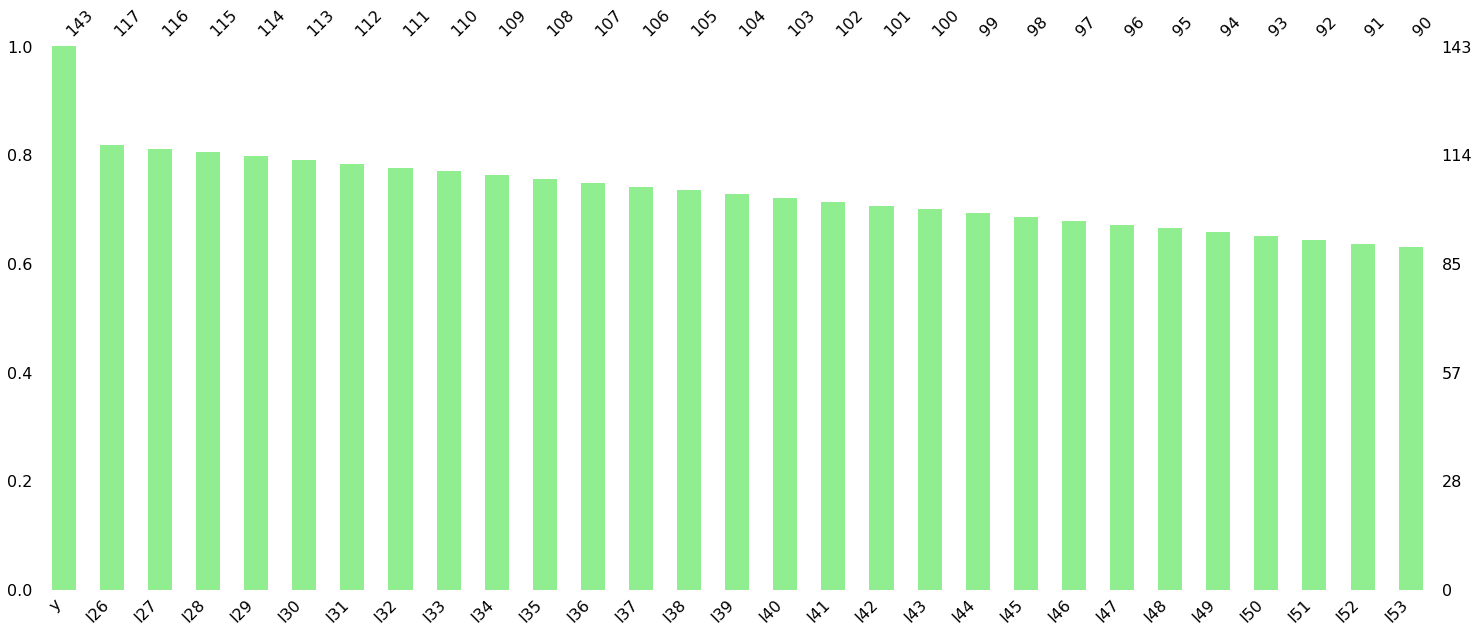

In [ ]:
# Adding lags
l_ts = pd.DataFrame(ts1)
l_ts.columns = ["y"]

for i in range(26, 54):
    l_ts[f"l{i}"] = l_ts.y.shift(i)
    
msno.bar(l_ts,color="lightgreen")

(90, 29)

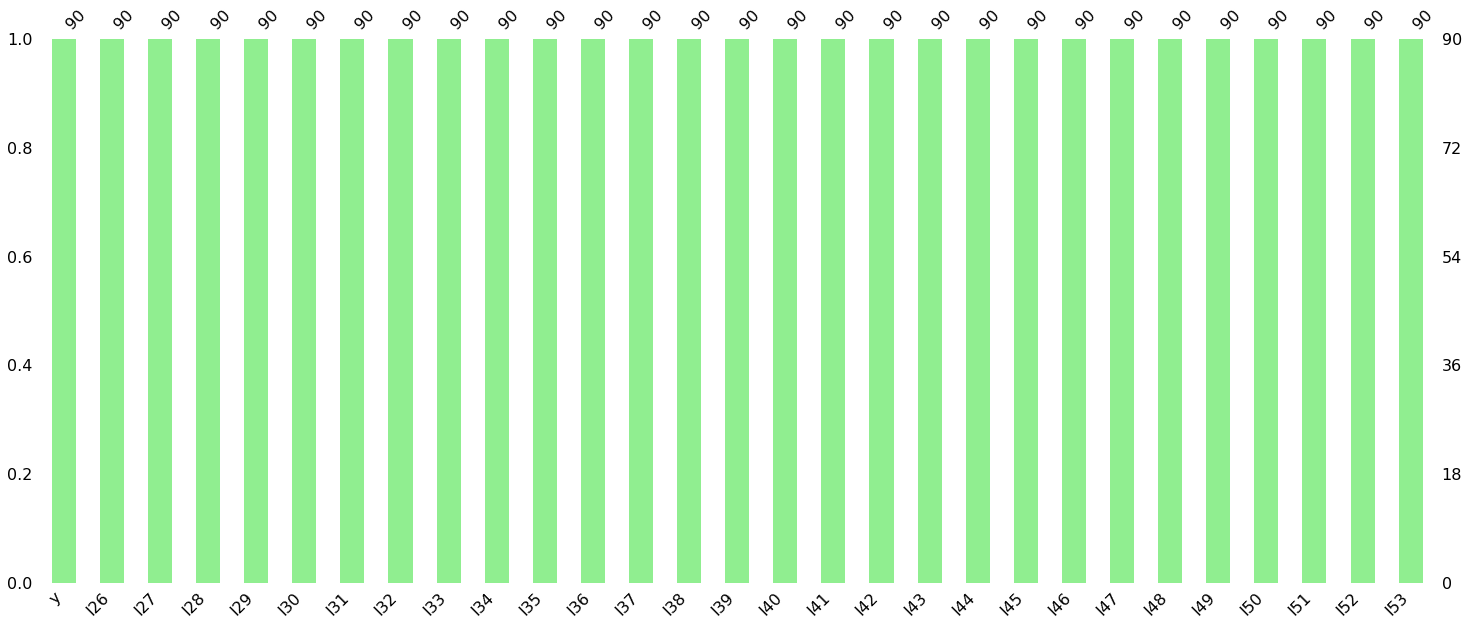

In [ ]:
# Drop NANs
l_ts.dropna(inplace=True)
msno.bar(l_ts,color="lightgreen");
l_ts.shape

In [ ]:
 #  5 folds cross-validation
tscv = TimeSeriesSplit(n_splits=5)

def ts_train_test_split(X, y, test_size):
    index = int(test_size*len(X))+1
    
    X_train = X.iloc[:-index]
    y_train = y.iloc[:-index]
    X_test = X.iloc[-index:]
    y_test = y.iloc[-index:]
    
    return X_train, X_test, y_train, y_test

In [ ]:
# Culaculate MAE
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
# Visualize the Mean Absolute error
def plotLMResults(model, X_train, X_test):
    pred = model.predict(X_test)
    
    fig = go.Figure()
    fig.add_trace(
        go.Scatter(
            x=X.index,
            y=y,
            name="Actual",
        ))
    fig.add_trace(
        go.Scatter(
            x=X_test.index,
            y=pred,
            name="Model",
        ))

    cv = cross_val_score(model, X_train, y_train, cv=tscv, scoring="neg_mean_squared_error")
    
    deviation = np.sqrt(cv.std())
    lower = pred - (1.5 * deviation)
    upper = pred + (1.5 * deviation)
    
    fig.add_trace(
        go.Scatter(
            x=X_test.index,
            y=lower,
            name="lower bond",
            line = dict(shape = 'linear', color = 'rgb(255, 12, 24)', width=0.7, dash = 'dash')
        ))
    fig.add_trace(
        go.Scatter(
            x=X_test.index,
            y=upper,
            name="upper bond",
            line = dict(shape = 'linear', color = 'rgb(255, 12, 24)', width=0.7, dash = 'dash')
        ))
    
    error = mean_absolute_percentage_error(pred, y_test)
    fig.update_layout(
        title= f"Mean Absolute Percentage Error: {error:.2f}%",
        xaxis_title="weeks",
        yaxis_title="sales",
        yaxis_tickprefix = '$',
        font=dict(
            family="Courier New, monospace",
            size=18,
            color="RebeccaPurple"
        ))
    fig.update_xaxes(rangeslider_visible=True)
    fig.show()
    
def plotCoefs(model):
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    fig = px.bar(coefs.coef)
    fig.update_yaxes(zeroline=True, zerolinewidth=2, zerolinecolor='gold')
    fig.show()
    

y = l_ts.y
X = l_ts.drop(['y'], axis=1)

X_train, X_test, y_train, y_test = ts_train_test_split(X, y, test_size=0.3)

lr = LinearRegression()
lr.fit(X_train, y_train)

plotLMResults(lr, X_train, X_test)
plotCoefs(lr)